In [1]:
!pip install onnx

In [1]:
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config
from zoedepth.models.zoedepth.zoedepth_v1 import ZoeDepth
import torch

# ZoeD_N

conf = get_config("zoedepth", "infer")
# model_zoe_n = build_model(conf)
#model=ZoeDepth.build_from_config(conf)
#model=ZoeDepth.build(**conf)

C:\Users\daimonyuusuke\anaconda3\envs\zoe\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.transforms import Normalize    

In [8]:
core = torch.hub.load(repo_or_dir="intel-isl/MiDaS",model="DPT_BEiT_L_384",
                               pretrained=True, force_reload=False)

Using cache found in C:\Users\daimonyuusuke/.cache\torch\hub\intel-isl_MiDaS_master


In [ ]:
class MidasCore(nn.Module):
    def __init__(self):
        self.prep = PrepForMidas(keep_aspect_ratio=keep_aspect_ratio,
                                 img_size=img_size, do_resize=kwargs.get('do_resize', True))
        img_size = kwargs.pop("img_size", [384, 384])
        self.core = torch.hub.load(repo_or_dir="intel-isl/MiDaS",model="DPT_BEiT_L_384",
                               pretrained=True, force_reload=False)
        
        
    def forward(self, x, denorm=False, return_rel_depth=True):
        with torch.no_grad():
            x = self.prep(x)
            rel_depth = self.core(x)
            if not self.fetch_features:
                return rel_depth
        out = [self.core_out[k] for k in self.layer_names]

        if return_rel_depth:
            print("aaaaaaaa")
            return rel_depth, out
        return out  

In [2]:
conf

{'save_dir': 'C:\\Users\\daimonyuusuke/shortcuts/monodepth3_checkpoints',
 'project': 'ZoeDepth',
 'tags': '',
 'notes': '',
 'gpu': None,
 'root': '.',
 'uid': None,
 'print_losses': False,
 'dataset': 'nyu',
 'distributed': True,
 'workers': 16,
 'clip_grad': 0.1,
 'use_shared_dict': False,
 'shared_dict': None,
 'use_amp': False,
 'aug': True,
 'random_crop': False,
 'random_translate': False,
 'translate_prob': 0.2,
 'max_translation': 100,
 'validate_every': 0.25,
 'log_images_every': 0.1,
 'prefetch': False,
 'name': 'ZoeDepth',
 'version_name': 'v1',
 'n_bins': 64,
 'bin_embedding_dim': 128,
 'bin_centers_type': 'softplus',
 'n_attractors': [16, 8, 4, 1],
 'attractor_alpha': 1000,
 'attractor_gamma': 2,
 'attractor_kind': 'mean',
 'attractor_type': 'inv',
 'midas_model_type': 'DPT_BEiT_L_384',
 'min_temp': 0.0212,
 'max_temp': 50.0,
 'output_distribution': 'logbinomial',
 'memory_efficient': True,
 'inverse_midas': False,
 'img_size': [384, 512],
 'train_midas': False,
 'use_pre

In [3]:
from zoedepth.models.base_models.midas import MidasCore
def build(midas_model_type="DPT_BEiT_L_384", pretrained_resource=None, use_pretrained_midas=False, train_midas=False, freeze_midas_bn=True, **kwargs):
        img_size = kwargs.pop("img_size", [384, 384])
        print("img_size", img_size)
        
        midas = torch.hub.load("intel-isl/MiDaS", "DPT_BEiT_L_384",
                               pretrained=True, force_reload=False)
        kwargs.update({'keep_aspect_ratio': False})
        core = MidasCore(midas, trainable=False, fetch_features=False,
                               freeze_bn=True, img_size=img_size, **kwargs)
        core.set_output_channels("DPT_BEiT_L_384")

        
        model = ZoeDepth(core, **kwargs)
        pretrained_resource='url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt'
        url = pretrained_resource.split('url::')[1]
        state_dict = torch.hub.load_state_dict_from_url(url, map_location='cpu', progress=True)
        state_dict= state_dict.get('model', state_dict)
        state = {}
        for k, v in state_dict.items():
            if k.startswith('module.') :
                k = k[7:]
        
            state[k] = v
            
        
        model.load_state_dict(state)
        return model

In [4]:
 model=build(**conf)

img_size [384, 512]


Using cache found in C:\Users\daimonyuusuke/.cache\torch\hub\intel-isl_MiDaS_master
C:\Users\daimonyuusuke\anaconda3\envs\zoe\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  False
	ensure_multiple_of:  32
	resize_method:  minimal


In [5]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#zoe = model_zoe_n.to(DEVICE)
zoemodel=model.to(DEVICE)

In [6]:
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

path=r"131219.png"
image = Image.open(path).convert("RGB")
x=transforms.ToTensor()(image).unsqueeze(0).to(DEVICE)
zoemodel.eval()
output=zoemodel(x)['metric_depth']

output=output.cpu().detach().squeeze().numpy()
plt.imshow(output, cmap='gray')

ValueError: not enough values to unpack (expected 2, got 1)

In [22]:
torch.onnx.export(    zoemodel,               # model being run
                      x,                         # model input (or a tuple for multiple inputs)
                      "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                      export_params=True,        # store the trained parameter weights inside the model file
                      opset_version=15,          # the ONNX version to export the model to
                      do_constant_folding=True,  # whether to execute constant folding for optimization
                      input_names = ['input'],   # the model's input names
                      output_names = ['output'], # the model's output names
                      dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                    'output' : {0 : 'batch_size'}})

AttributeError: 'Tensor' object has no attribute 'astype'

In [20]:
output.shape

(550, 1110)

{}
{}


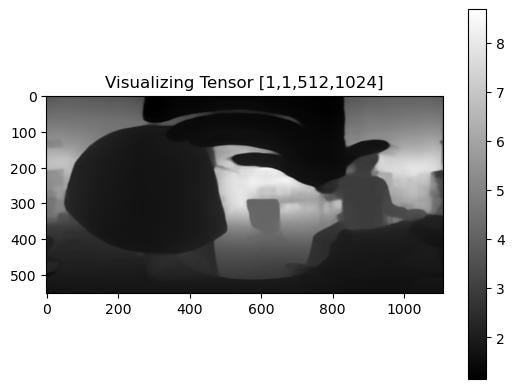

In [7]:
from PIL import Image
path=r"f98f146eba5a102cb3441b0963f3c57e.png"
image = Image.open(path).convert("RGB")  # load
"""depth_numpy = zoe.infer_pil(image)  # as numpy

depth_pil = zoe.infer_pil(image, output_type="pil")  # as 16-bit PIL Image

depth_tensor = zoe.infer_pil(image, output_type="tensor")  # as torch tensor

# Tensor 
from zoedepth.utils.misc import pil_to_batched_tensor
X = pil_to_batched_tensor(image).to(DEVICE)
depth_tensor = zoe.infer(X)"""

import torch
import numpy as np
import matplotlib.pyplot as plt



# GPUからCPUに移動し、勾配を切り離してからNumPy配列に変換
out=zoemodel.infer_pil(image, output_type="tensor")
image = zoemodel.infer_pil(image, output_type="tensor").cpu().detach().squeeze().numpy()
# 画像を可視化
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('Visualizing Tensor [1,1,512,1024]')
plt.show()


In [8]:
out.shape

torch.Size([550, 1110])

In [7]:
image

array([[3.6450214, 3.646096 , 3.6486206, ..., 3.646031 , 3.6118784,
        3.5919292],
       [3.6652002, 3.6663375, 3.6688347, ..., 3.6630623, 3.6275191,
        3.607378 ],
       [3.683909 , 3.6852298, 3.6877427, ..., 3.6844165, 3.6483676,
        3.629043 ],
       ...,
       [1.6729652, 1.6762214, 1.6819503, ..., 1.6221352, 1.6145883,
        1.6094186],
       [1.6713359, 1.674233 , 1.6795435, ..., 1.6178396, 1.6107032,
        1.605874 ],
       [1.6714222, 1.6738592, 1.6786078, ..., 1.6143725, 1.6077235,
        1.6033026]], dtype=float32)

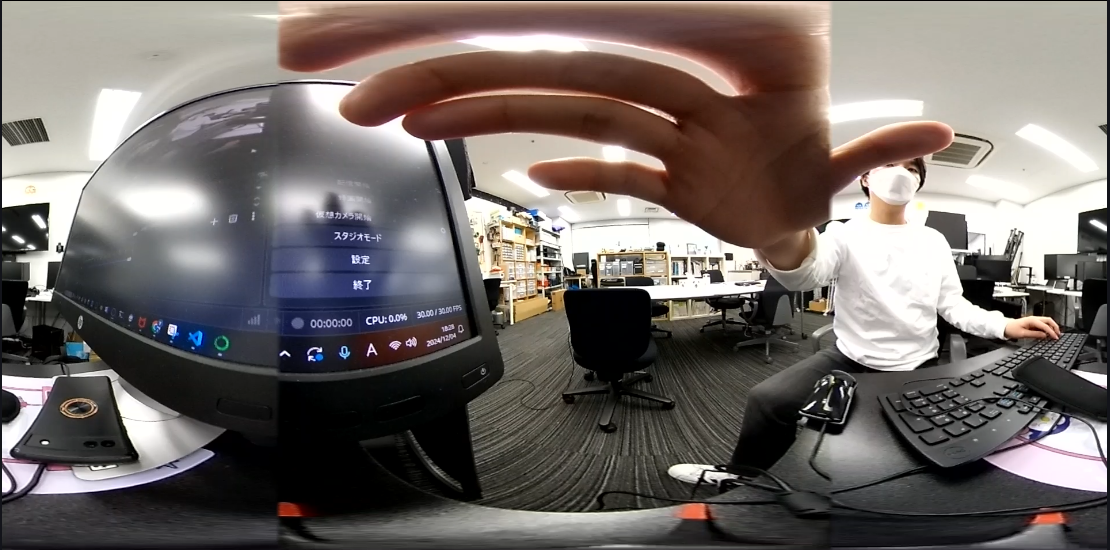

In [5]:
image

In [6]:
X

tensor([[[[0.0745, 0.0745, 0.0000,  ..., 0.0745, 0.0745, 0.0745],
          [0.0745, 0.0745, 0.7176,  ..., 0.0745, 0.0745, 0.0745],
          [0.0745, 0.0745, 0.7176,  ..., 0.0745, 0.0745, 0.0745],
          ...,
          [0.0745, 0.0745, 0.0706,  ..., 0.0745, 0.0745, 0.0745],
          [0.0745, 0.0745, 0.0980,  ..., 0.0745, 0.0745, 0.0745],
          [0.0745, 0.0745, 0.1412,  ..., 0.0745, 0.0745, 0.0745]],

         [[0.0784, 0.0784, 0.0000,  ..., 0.0784, 0.0784, 0.0784],
          [0.0784, 0.0784, 0.7137,  ..., 0.0784, 0.0784, 0.0784],
          [0.0784, 0.0784, 0.7137,  ..., 0.0784, 0.0784, 0.0784],
          ...,
          [0.0784, 0.0784, 0.0706,  ..., 0.0784, 0.0784, 0.0784],
          [0.0784, 0.0784, 0.0980,  ..., 0.0784, 0.0784, 0.0784],
          [0.0784, 0.0784, 0.1412,  ..., 0.0784, 0.0784, 0.0784]],

         [[0.1020, 0.1020, 0.0000,  ..., 0.1020, 0.1020, 0.1020],
          [0.1020, 0.1020, 0.6627,  ..., 0.1020, 0.1020, 0.1020],
          [0.1020, 0.1020, 0.6627,  ..., 0

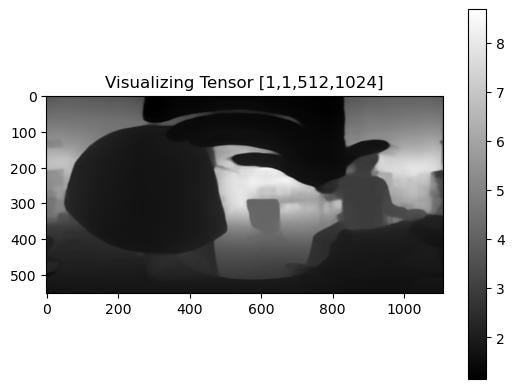

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt



# GPUからCPUに移動し、勾配を切り離してからNumPy配列に変換
image = depth_tensor.cpu().detach().squeeze().numpy()
# 画像を可視化
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('Visualizing Tensor [1,1,512,1024]')
plt.show()


In [10]:
torch.onnx.export(    zoe,               # model being run
                      depth_tensor,                         # model input (or a tuple for multiple inputs)
                      "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                      export_params=True,        # store the trained parameter weights inside the model file
                      opset_version=15,          # the ONNX version to export the model to
                      do_constant_folding=True,  # whether to execute constant folding for optimization
                      input_names = ['input'],   # the model's input names
                      output_names = ['output'], # the model's output names
                      dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                    'output' : {0 : 'batch_size'}})

AttributeError: 'Tensor' object has no attribute 'astype'